### Setting up Pyspark in IBM Watson Studio

* Installing pyspark
* Importing required packages to create Spark Sessions
* Setting the connection to the Spark cluster with SparkContext
* Setting the SparkSession to enable the SQL like syntax to work with Spark Dataframes

In [1]:
!pip install pyspark==2.4.5

In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.getOrCreate()

Getting the data from the IBM course page

In [5]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-06-13 10:21:26--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-06-13 10:21:26--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-06-13 10:21:26--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

Creating the PySpark dataframe

In [6]:
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

Since the data is an IoT based sensor measurements, a little feature engineering is done with a sliding window approach to make relevant features for each window. This can be done by using the SQL queries as shown below. [source](https://www.coursera.org/learn/ds)

In [7]:
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

The maximum and minimum values of each sensor signal for a the specified window size of 10 are collected from the actual data to form the result dataframe. Also all the null valued rows are ignored in each window.

In [8]:
result.show()

+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+
|min_temperature|max_temperature|min_voltage|max_voltage|min_flowrate|max_flowrate|min_frequency|max_frequency|min_hardness|max_hardness|min_speed|max_speed|
+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+
|             81|            100|        221|        223|          11|          11|           68|           76|          71|          78|     1033|     1033|
|             81|            100|        221|        223|          11|          11|           68|           76|          72|          78|     1033|     1033|
|             81|            100|        221|        223|          11|          11|           68|           76|          72|          80|     1033|     1033|
|             81|            100|        222|       

Now as we have the extracted the required features from the raw sensor measurements. We can perform further analysis like PCA to understand the process. With this we can identify different operating conditions of the washing machine based on the sensor signals. 

To perform PCA on a SparkDataframe the pyspark.ml API needs to be used. Any model from .ml API expects the data to be in the form of a column which has vectors as rows i.e. each row is a vector of all the features in the dataframe. This data preparation is done with the help of VectorAssembler functionality in pyspark.

In [9]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

The vector assembler is initialized with the input column names of the data that are to be converted into vectors and the output column of the vectorizer can be set here.  

In [10]:
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")

Now the initialized assembler is used to transform the data. All the operations in the pyspark.ml library are optimized to run with parellalization, which is very optimized and fast.

In [11]:
features = assembler.transform(result)

In [13]:
features.show()

+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+--------------------+
|min_temperature|max_temperature|min_voltage|max_voltage|min_flowrate|max_flowrate|min_frequency|max_frequency|min_hardness|max_hardness|min_speed|max_speed|            features|
+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+--------------------+
|             81|            100|        221|        223|          11|          11|           68|           76|          71|          78|     1033|     1033|[81.0,100.0,221.0...|
|             81|            100|        221|        223|          11|          11|           68|           76|          72|          78|     1033|     1033|[81.0,100.0,221.0...|
|             81|            100|        221|        223|          11|          11|           68|        

As seen here, a new column called 'features' has been added to the data which contains the same data in the form of vetors. We can access this features column as shown below.

In [14]:
features.rdd.map(lambda r : r.features).take(10)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

#### Performing PCA
Now the PCA object can be initialized with the required parameters and then the .fit() method can be used to fit on the data. Again the input column and the output column names are specified in the PCA object itself. 

In [15]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

After the model is fit on the data, it can be transformed now using the .transform() method this will return a new column wth the column name as specified during the initialization.

In [16]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[1459.9789705814187,-18.745237781780922,70.78430794796873] |
|[1459.995481828676,-19.11343146165273,70.72738871425986]   |
|[1460.0895843561282,-20.969471062922928,70.75630600322052] |
|[1469.6993929419532,-20.403124647615513,62.013569674880955]|
|[1469.7159041892107,-20.771318327487293,61.95665044117209] |
|[1469.7128317338704,-20.790751117222456,61.896106678330966]|
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1483.5412027684088,-20.006222577501354,66.82710394284209] |
|[1483.5171090223353,-20.867020421583753,66.86707301954084] |
|[1483.4224268542928,-19.87574823665505,66.93027077913985]  |
|[1483.4

#### Visualizing PCA Features

Since all the data cannot fit into a single machine, the data has to be sampled in order to plot it. And each feature has to be seperated into three different arrays by accessing the corresponding element from each vector.

In [17]:
rdd = result_pca.rdd.sample(False,0.8)

pca1 = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()
pca2 = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()
pca3 = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

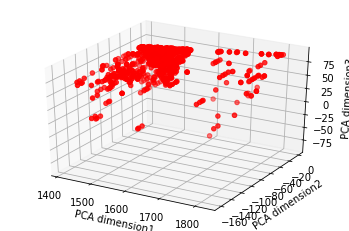

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca1,pca2,pca3, c='r', marker='o')

ax.set_xlabel('PCA dimension1')
ax.set_ylabel('PCA dimension2')
ax.set_zlabel('PCA dimension3')

plt.show()